This is a notebook created by Alexandros Angelakis, Computer Science Department, University of Crete, supervised by Dr. Yannis Pantazis, Institute of Applied and Computational Mathematics of the Foundation of Research and Technology Hellas. This notebook is about two algorithms that we developed, one that finds a solution to the optimal sensor placement problem and one that finds a solution to the leakage problem. We are going to run the two algorithms on a random tree graph example. For more information about the algorithms look at the "Optimal Sensor Placement Algorithm using WDNs with GIS" notebook and our paper (TBA).

In [ ]:
# imports
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import math

Helper functions.

In [4]:
# Finds the edges with length > sensor range and fixes them
def add_new_nodes_edges_graph(graph, pos, sensor_range):
    new_nodes = []
    new_nodes_pos = []
    new_edges = []
    for edge in graph.edges:
        distance = graph.edges[edge]['length']
        (node1, node2) = edge
        old_node1 = node1
        if distance > sensor_range:
            cuts = math.ceil(distance / sensor_range)
            new_edges_num = cuts
            new_nodes_num = cuts - 1

            (node1_x, node1_y) = pos[node1]
            (node2_x, node2_y) = pos[node2]

            for i in range(new_nodes_num):
                new_y = (abs(node2_y - node1_y) / cuts) + min(node1_y, node2_y)
                new_x = (abs(node2_x - node1_x) / cuts) + min(node1_x, node2_x)

                new_nodes.append((new_x, new_y))
                new_nodes_pos.append((new_x, new_y))
                new_edges.append((node1, (new_x, new_y)))

                node1_y = new_y
                node1_x = new_x
                node1 = (new_x, new_y)
            new_edges.append((node1, node2))
            graph.remove_edge(old_node1, node2)

    for i in range(len(new_nodes)):
        graph.add_node(new_nodes[i])
        pos[new_nodes[i]] = new_nodes_pos[i]
        graph.nodes[new_nodes[i]]['new'] = 'yes'

    for i in range(len(new_edges)):
        (x, y) = new_edges[i]
        graph.add_edge(x, y)

        
# This function plots a graph with its sensors
def print_graph_with_sensors(graph, start, pos, title=''):
    node_color_map = []
    edge_color_map = []
    for i in range(graph.number_of_nodes()):
        if i == start and graph.nodes[i]['sensor'] == 'yes':
            node_color_map.append('cyan')
        elif i == start:
            node_color_map.append('green')
        elif graph.nodes[i]['sensor'] == 'yes':
            node_color_map.append('red')
        elif graph.nodes[i]['new'] == 'yes':
            node_color_map.append('yellow')
        else:
            node_color_map.append('blue')

    for edge in graph.edges:
        if graph.edges[edge]['possible_leakage'] == 'yes':
            edge_color_map.append('green')
        else:
            edge_color_map.append('red')

    lengths = nx.get_edge_attributes(graph, 'length')
    plt.figure(figsize=(25, 25))
    plt.title(title)
    nx.draw(graph, pos, with_labels=True, font_size=10, node_color=node_color_map, edge_color=edge_color_map)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=lengths, font_size=7)         

    
# Finds the edges with length > sensor range and fixes them (int nodes)
def add_new_nodes_edges_int_graph(graph, pos, sensor_range):
    new_nodes = []
    new_nodes_pos = []
    new_edges = []
    number_of_nodes = graph.number_of_nodes()
    for edge in graph.edges:
        distance = graph.edges[edge]['length']
        (node1, node2) = edge
        old_node1 = node1
        if distance > sensor_range:
            cuts = math.ceil(distance / sensor_range)
            new_edges_num = cuts
            new_nodes_num = cuts - 1

            (node1_x, node1_y) = pos[node1]
            (node2_x, node2_y) = pos[node2]

            for i in range(new_nodes_num):
                new_y = (abs(node2_y - node1_y) / cuts) + min(node1_y, node2_y)
                new_x = (abs(node2_x - node1_x) / cuts) + min(node1_x, node2_x)

                new_nodes.append(number_of_nodes)
                new_nodes_pos.append((new_x, new_y))
                new_edges.append((node1, number_of_nodes))

                node1_y = new_y
                node1_x = new_x
                node1 = number_of_nodes
                number_of_nodes += 1
            new_edges.append((node1, node2))
            graph.remove_edge(old_node1, node2)

    for i in range(len(new_nodes)):
        graph.add_node(new_nodes[i])
        pos[new_nodes[i]] = new_nodes_pos[i]
        graph.nodes[new_nodes[i]]['new'] = 'yes'

    for i in range(len(new_edges)):
        (x, y) = new_edges[i]
        graph.add_edge(x, y)
        

# This function find all the positions of the graph's nodes.
def find_node_positions(graph):
    G_positions = {}
    for index, n in enumerate(list(graph.nodes)):
        G_positions[index] = [n[0], n[1]]
    return G_positions
        

# Initializes our graph without the 'new' attribute
def initialize_graph_without_new(graph):
    nx.set_edge_attributes(graph, 0, 'length')
    nx.set_edge_attributes(graph, 'no', 'possible_leakage')
    nx.set_edge_attributes(graph, 'no', 'covered')
    nx.set_node_attributes(graph, 'no', 'sensor')


# Initializes our graph.
def initialize_graph(graph):
    nx.set_edge_attributes(graph, 0, 'length')
    nx.set_edge_attributes(graph, 'no', 'possible_leakage')
    nx.set_edge_attributes(graph, 'no', 'covered')
    nx.set_node_attributes(graph, 'no', 'sensor')
    nx.set_node_attributes(graph, 'no', 'new')
    

# Finds the length of each edge using the BFS algorithm.
def find_length(G, pos, start):
    explored = []
    queue = [start]

    while queue:
        node = queue.pop(0)
        while node in queue:  # <--- Fixed a bug where graph.edges[][] has invalid keys
            queue.remove(node)

        if node not in explored:
            explored.append(node)
            neighbours = (list(G.adj.items())[node])[1]

        for next in neighbours:
            if (next not in explored):
                G.edges[(node, next)]['length'] = round(math.dist(pos[node], pos[next]), 3)
                queue.append(next)

Let's create a random tree using the Networkx's library, plot it and test our algorithms on it.

Graph with 60 nodes and 59 edges


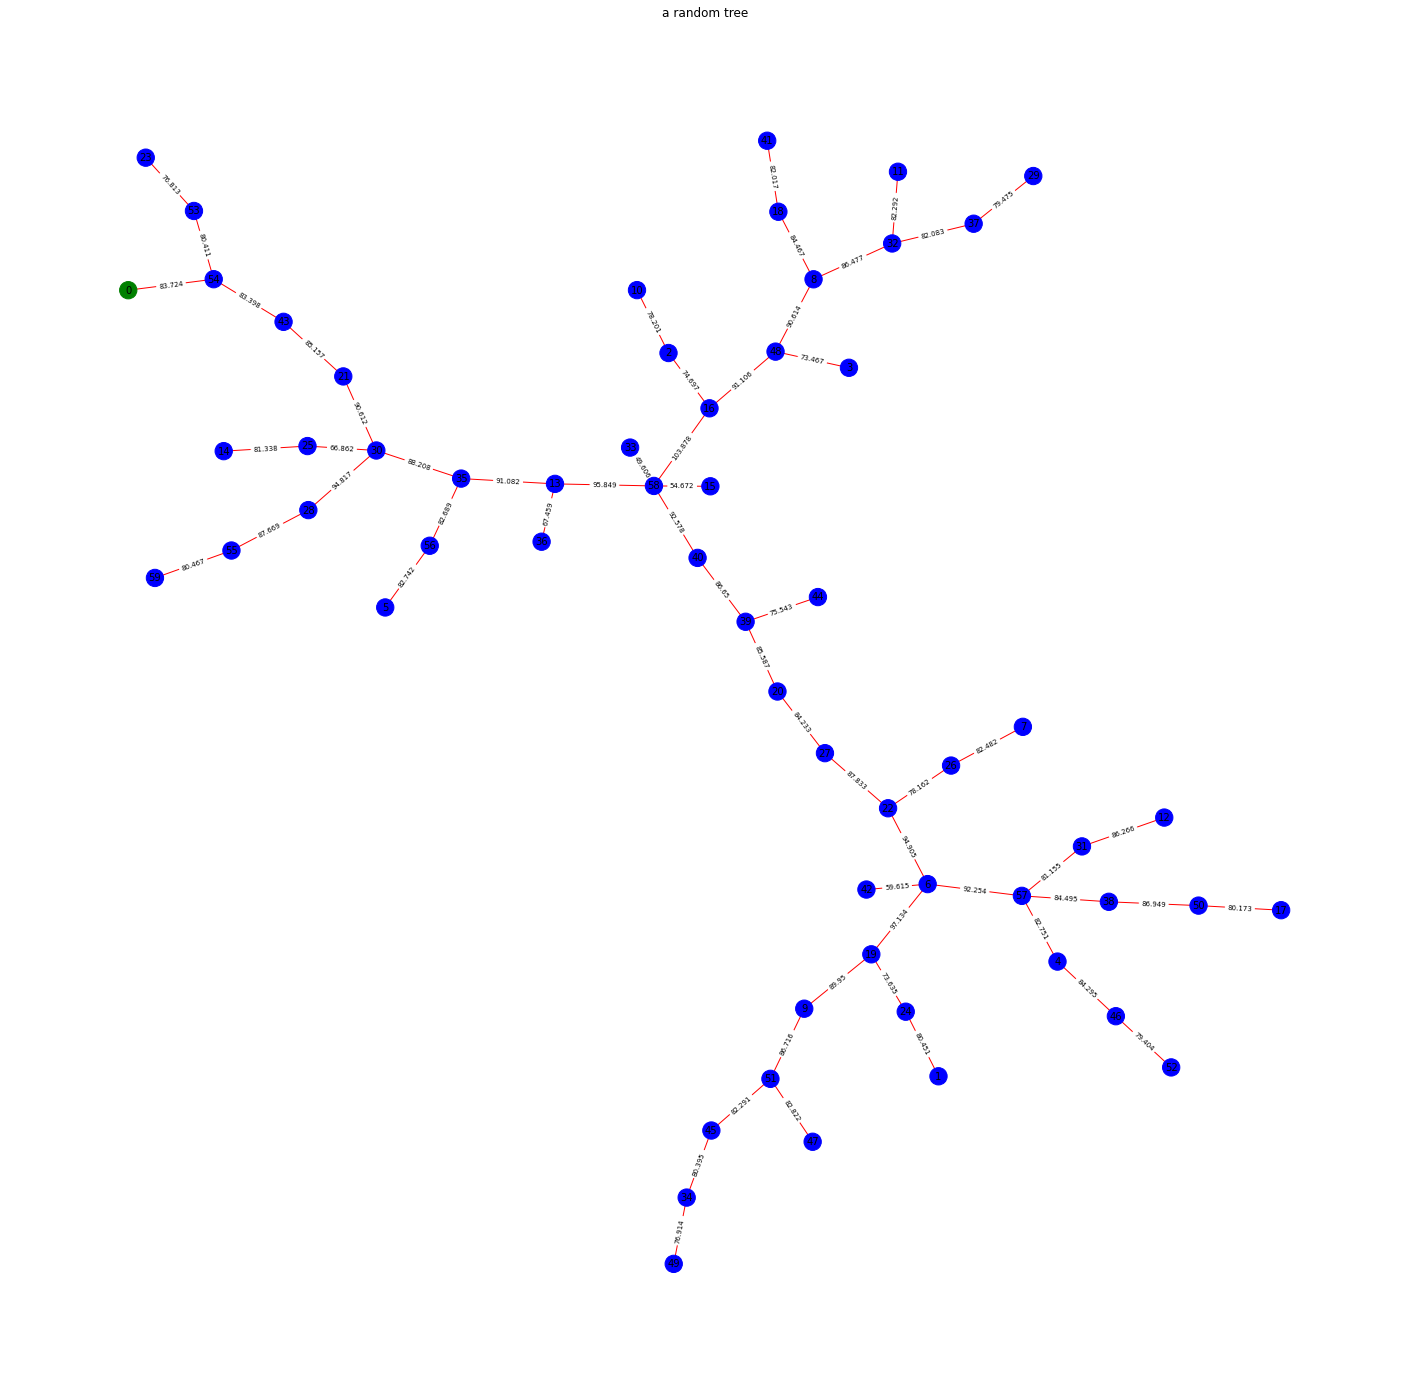

In [5]:
# Creating a random tree
G = nx.random_tree(n=60, seed=0)
print(G)
tree = nx.convert_node_labels_to_integers(G)
pos = nx.nx_agraph.graphviz_layout(tree, prog="neato", args="")

# Initialize the tree with our attributes
initialize_graph(tree)

# Find the lengths of the edges
find_length(tree, pos, 0)

start = 0
sensor_range = 200

# Adding new nodes/edges if needed (there is an edge where length > sensor range)
add_new_nodes_edges_int_graph(tree, pos, sensor_range)

# Initialize the graph one more time
initialize_graph(tree)

# Find the lengths of the new edges
find_length(tree, pos, 0)

# Plot the random tree
print_graph_with_sensors(tree, 0, pos, title='a random tree')

The coverage algorithm. For more information about the algorithm, look at the "Optimal Sensor Placement Algorithm using WDNs with GIS" notebook and our paper (TBA).

In [6]:
# Using the BFS Algorithm to decide the places of the sensors based on the edges' lengths
def sensors_coverage_problem(graph, start, sensor_range):
    explored = []
    queue = [start]
    lengths = {}
    sensor_coverage = {}
    sensors = []

    while queue:
        node = queue.pop(0)
        while node in queue:
            queue.remove(node)

        if node not in explored:
            explored.append(node)
            neighbours = (list(graph.adj.items())[node])[1]

        tmp = {}
        node_is_sensor = 0
        for next in neighbours:
            if next not in explored:
                found = 0
                tmp[(node, next)] = graph.edges[node, next]['length']
                for n in lengths:  # Searching in the lengths to find the previous length in the path to add it
                    for i in range(
                            graph.number_of_nodes()):  # Don't add all the lengths found, only one is required(if found)
                        if (i, node) in lengths[n]:
                            if found == 0:
                                tmp[(node, next)] += lengths[n][(i, node)]
                                found = 1
                                break

                    if found == 1:
                        break

                # Make the starting node a sensor and move on
                if len(lengths) == 0:
                    if node not in sensors:
                        sensors.append(node)
                        node_is_sensor = 1
                        graph.nodes[node]['sensor'] = 'yes'

                if tmp[(node, next)] > sensor_range:
                    if graph.edges[node, next]['covered'] == 'no':
                        if node not in sensors:
                            graph.nodes[node]['sensor'] = 'yes'
                            sensors.append(node)
                            node_is_sensor = 1

                queue.append(next)
        if node_is_sensor:
            sensor_coverage[node] = find_covered_edges_from_sensor(graph, node, sensor_range)
        lengths[node] = tmp
    return sensors, sensor_coverage


# Function that finds the edges of the graph the sensor given is covering
def find_covered_edges_from_sensor(graph, sensor, sensor_range):
    explored = []
    queue = [sensor]
    lengths = {}
    node_coverage = []
    sensor_leakage_paths = {}

    while queue:
        node = queue.pop(0)
        while node in queue:  # <--- Fixed a bug where graph.edges[][] has invalid keys
            queue.remove(node)

        if node not in explored:
            explored.append(node)
            neighbours = (list(graph.adj.items())[node])[1]

        tmp = {}
        for next in neighbours:
            prev = -1
            if next not in explored:
                found = 0
                tmp[(node, next)] = graph.edges[node, next]['length']
                for n in lengths:  # Searching in the lengths to find the previous length in the path to add it
                    for i in range(
                            graph.number_of_nodes()):  # Don't add all the lengths found, only one is required(if found)
                        if (i, node) in lengths[n]:
                            if found == 0:
                                tmp[(node, next)] += lengths[n][(i, node)]
                                found = 1
                                prev = i

                    if found == 1:
                        break

                if tmp[(node, next)] <= sensor_range:
                    node_coverage.append((node, next))
                    graph.edges[node, next]['covered'] = 'yes'

                queue.append(next)
        lengths[node] = tmp
    return node_coverage

Let's run the coverage algorithm on this graph.

number of sensors after the coverage algorithm: 19


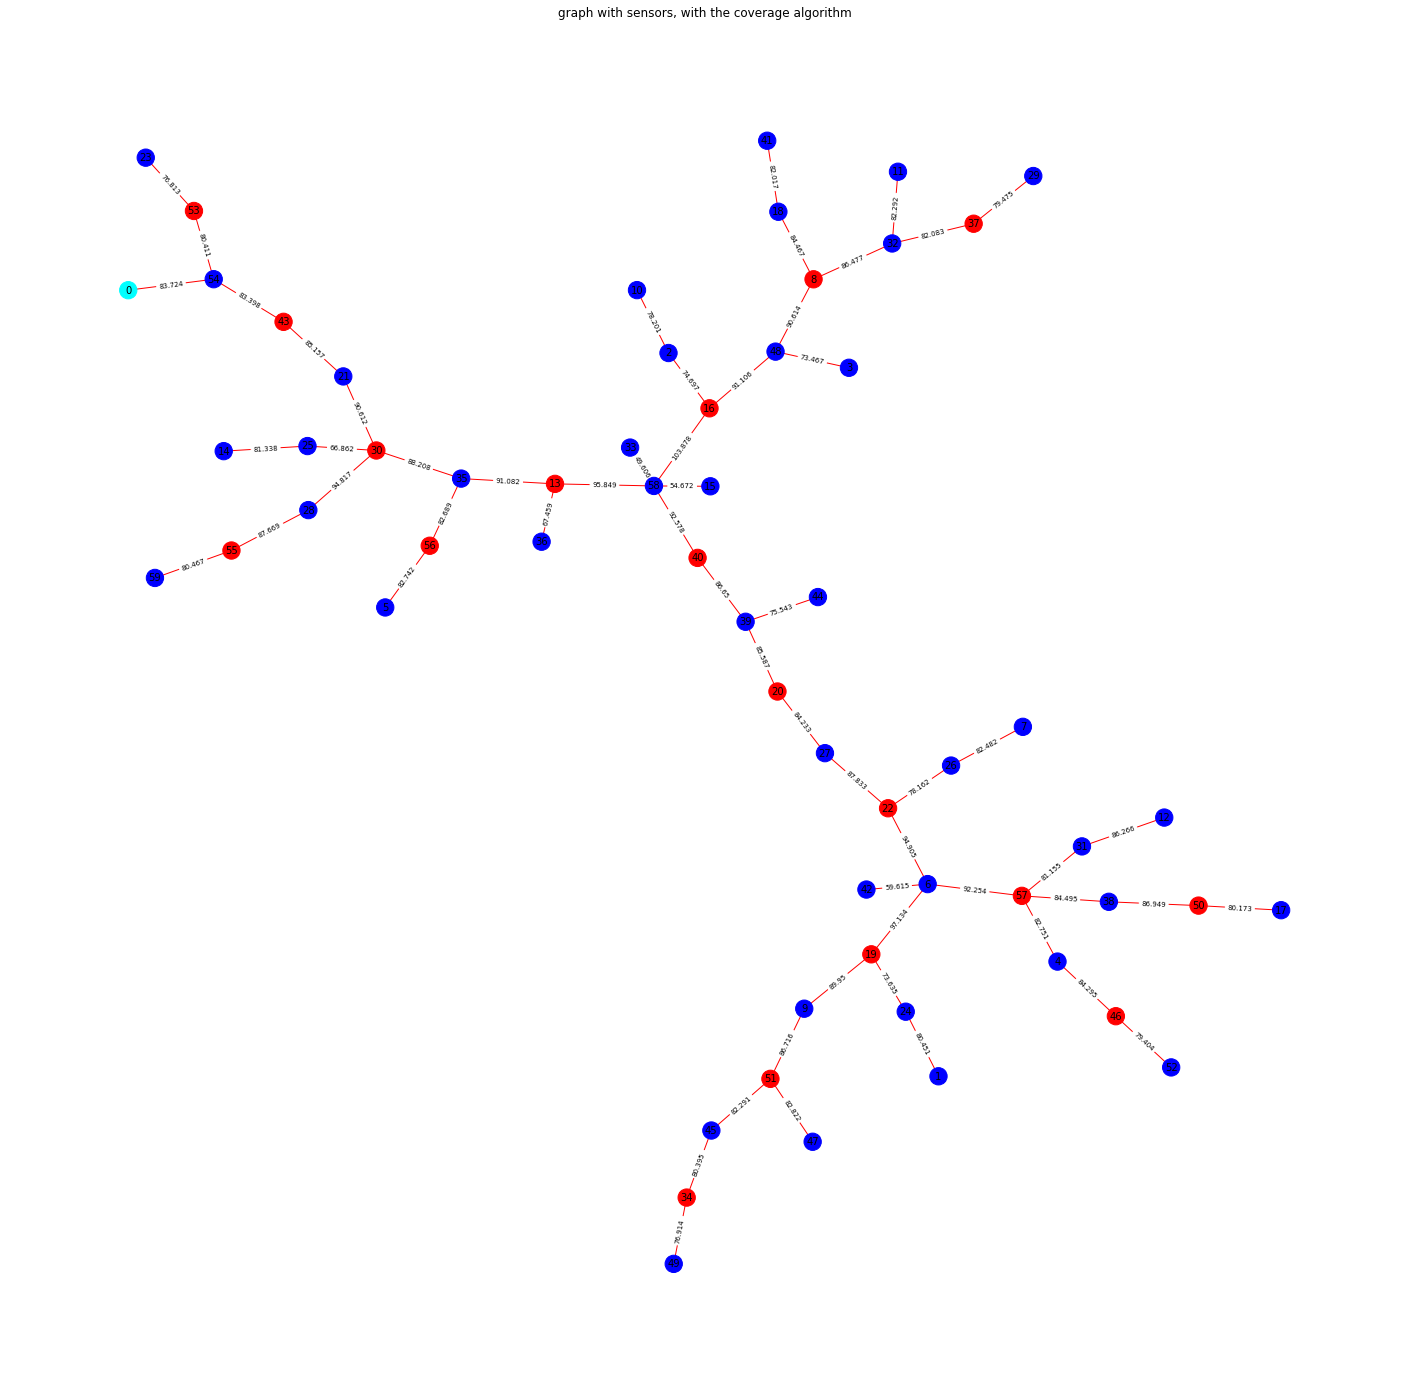

In [7]:
# Coverage Algorithm
sensors, sensor_coverage = sensors_coverage_problem(tree, start, sensor_range)

print('number of sensors after the coverage algorithm:', len(sensors))

# Plot the graph after the coverage algorithm
print_graph_with_sensors(tree, 0, pos, title='graph with sensors, with the coverage algorithm')

The coverage algorithm works perfect.
Let's see how the leakage algorithm runs.

The leakage algorithm. For more information about the algorithm, look at the "Optimal Sensor Placement Algorithm using WDNs with GIS" notebook and our paper (TBA).

In [8]:
# Algorithm that finds the leakage of a graph
def sensors_leakage_problem(G, sensor_coverage, sensor_range):
    # Find the possible leakage edges
    find_leakage(G, sensor_coverage, sensor_range)

    new_sensors = []

    # Place a sensor on each leaf of the graph
    for (x, y) in G.edges:
        if G.edges[(x, y)]['possible_leakage'] == 'yes':
            neighbours_x = (list(G.adj.items())[x])[1]
            neighbours_y = (list(G.adj.items())[y])[1]
            if len(neighbours_x) == 1:
                G.nodes[x]['sensor'] = 'yes'
                new_sensors.append(x)
                sensor_coverage[x] = find_covered_edges_from_sensor(G, x, sensor_range)
                find_leakage_sensor(G, x, sensor_coverage, sensor_range)
            elif len(neighbours_y) == 1:
                G.nodes[y]['sensor'] = 'yes'
                new_sensors.append(y)
                sensor_coverage[y] = find_covered_edges_from_sensor(G, y, sensor_range)
                find_leakage_sensor(G, y, sensor_coverage, sensor_range)

    # Place a sensor to cover all the possible leakage edges
    for (x, y) in G.edges:
        if G.edges[(x, y)]['possible_leakage'] == 'yes':
            G.nodes[y]['sensor'] = 'yes'
            new_sensors.append(y)
            sensor_coverage[y] = find_covered_edges_from_sensor(G, y, sensor_range)
            find_leakage_sensor(G, y, sensor_coverage, sensor_range)

    # Find the edges that are not explored because of the shortest path algorithm and fix them
    find_shortest_path_errors(G, sensor_coverage, sensor_range, new_sensors)

    
# Function that fixes the shortest path errors for the leakage problem.
def find_shortest_path_errors(G, sensor_coverage, sensor_range, new_sensors):
    remaining_possible_leakage = []
    for (x, y) in G.edges:
        if G.edges[(x, y)]['possible_leakage'] == 'yes':
            remaining_possible_leakage.append((x, y))

    xs = []
    ys = []
    # For each edge the shortest path algorithm didn't catch
    for (x, y) in remaining_possible_leakage:
        xs.append(x)
        ys.append(y)

    nodes = []
    for x in xs:
        if xs.count(x) > 1:
            nodes.append(x)
        else:
            continue

    for y in ys:
        if ys.count(y) > 1:
            nodes.append(y)
        else:
            continue

    nodes = list(dict.fromkeys(nodes))

    # make all nodes sensors temporarily, computer their paths and see if you can concat the two paths that contain a sensor
    paths = {}
    paths_length = []
    for node in nodes:
        G.nodes[node]['sensor'] = 'yes'
        new_sensors.append(node)
        sensor_coverage[node] = find_covered_edges_from_sensor(G, node, sensor_range)
        destinations = []
        for (x, y) in sensor_coverage[node]:
            if x == node or y == node:
                continue
            if G.nodes[x]['sensor'] == 'yes':
                destinations.append(x)
            elif G.nodes[y]['sensor'] == 'yes':
                destinations.append(y)
        destinations = list(dict.fromkeys(destinations))
        tmp_paths = [[]]
        tmp_paths.pop(0)
        for dest in destinations:
            for path in nx.all_shortest_paths(G, node, dest, weight='length'):
                tmp_length = 0
                for i in range(len(path) - 1):
                    tmp_length += G.edges[path[i], path[i + 1]]['length']
                paths_length.append(tmp_length)
                tmp_paths.append(path)
            paths[node] = tmp_paths

    for node in paths:
        for path1 in paths[node]:
            for path2 in paths[node]:
                if path1 == path2:
                    continue
                if path2[1] == path1[1]:
                    continue
                length1 = 0
                length2 = 0
                for i in range(len(path1) - 1):
                    length1 += G.edges[path1[i], path1[i + 1]]['length']
                for i in range(len(path2) - 1):
                    length2 += G.edges[path2[i], path2[i + 1]]['length']
                # print(f"path1: {path1} with length {length1} and path2: {path2} with length {length2}")
                if length1 + length2 <= sensor_range:
                    G.edges[(node, path1[1])]['possible_leakage'] = 'no'
                    G.edges[(node, path2[1])]['possible_leakage'] = 'no'

        G.nodes[node]['sensor'] = 'no'


# Finds the leakage edges a sensor can cover
def find_leakage_sensor(graph, sensor, sensor_coverage, sensor_range):
    paths = []
    # Find the possible leakage edges
    xs = []
    ys = []
    destinations = []
    for (x, y) in sensor_coverage[sensor]:
        xs.append(x)
        ys.append(y)
    for y in set(ys):
        if y not in set(xs):
            destinations.append(y)
    for dest in destinations:
        for path in nx.all_shortest_paths(graph, sensor, dest, weight='length'):
            paths.append(path)
            index_of_sensor = -1
            no_sensors = 0
            for node in path:
                index_of_sensor += 1
                if node != sensor and graph.nodes[node]['sensor'] == 'yes':
                    break
                elif node != sensor and graph.nodes[node]['sensor'] == 'no':
                    no_sensors += 1

            if no_sensors != (len(path) - 1):
                for i in range(0, index_of_sensor):
                    if graph.edges[path[i], path[i + 1]]['possible_leakage'] == 'yes':
                        graph.edges[path[i], path[i + 1]]['possible_leakage'] = 'no'
                        

# Function that finds all the possible leakage edges of the graph
def find_leakage(graph, sensor_coverage, sensor_range):
    paths = []
    # Find the possible leakage edges
    # with open("paths.txt", "a") as external_file:

    for sensor in sensor_coverage:
        xs = []
        ys = []
        destinations = []
        for (x, y) in sensor_coverage[sensor]:
            xs.append(x)
            ys.append(y)
        for y in set(ys):
            if y not in set(xs):
                destinations.append(y)
        for dest in destinations:
            for path in nx.all_shortest_paths(graph, sensor, dest, weight='length'):
                prev = path[-2]
                node = path[-1]
                paths.append(path)
                neighbours = (list(graph.adj.items())[node])[1]
                if len(neighbours) == 1:
                    graph.edges[(prev, node)]['possible_leakage'] = 'yes'
                elif graph.nodes[node]['sensor'] == 'no' and graph.nodes[prev]['sensor'] == 'no':
                    graph.edges[(prev, node)]['possible_leakage'] = 'yes'

    # Remove the invalid possible leakage edges
    for (x, y) in graph.edges:
        if graph.edges[(x, y)]['possible_leakage'] == 'yes':
            for path in paths:
                if x in path and y in path and (path.index(y) - path.index(x) == 1) and graph.nodes[path[-1]][
                    'sensor'] == 'yes':
                    graph.edges[(x, y)]['possible_leakage'] = 'no'


number of sensors after the leakage algorithm: 40


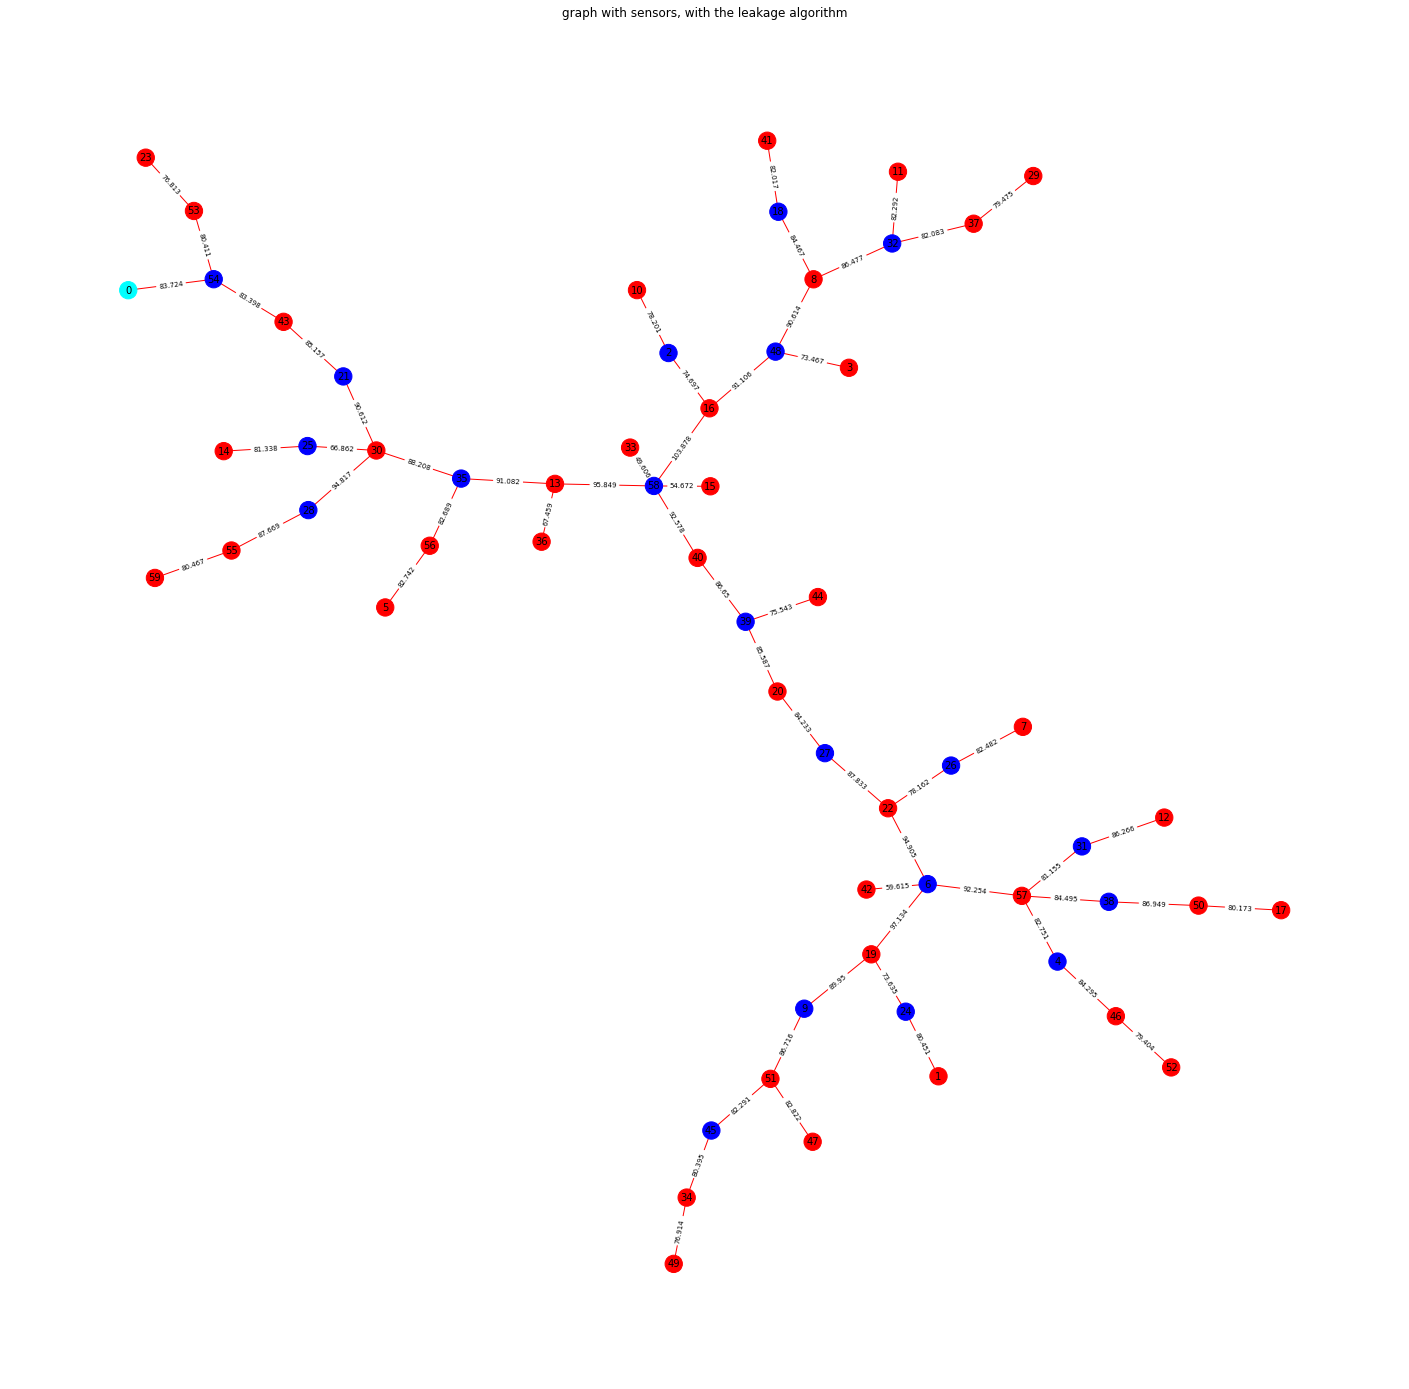

In [9]:
# Leakage Algorithm
sensors_leakage_problem(tree, sensor_coverage, sensor_range)

print('number of sensors after the leakage algorithm:', len(sensor_coverage))

# Plot the graph after the leakage problem
print_graph_with_sensors(tree, 0, pos, title='graph with sensors, with the leakage algorithm')

As we can see the algorithm runs perfectly and finds a solution for the leakage problem.